# Covariance matrix

In [44]:
import pandas as pd 
import numpy as np
import os 
import sys
from glob import glob
import pickle

import librosa
from scipy.io import wavfile
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.join(os.getcwd(), '..', 'utils'))

from restore import restore, restore_matrix
sns.set_theme()

%load_ext autoreload
%autoreload 2

path = os.getcwd()
path = os.path.join(path, 'data')

files = [f for f in glob(path + '/*.csv')]
files

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['/home/srg/Documents/git/EEG/pseudo-inverse/data_prep/data/bashirinzrf_och.csv']

In [59]:
sys.path

['/home/srg/Documents/git/EEG/pseudo-inverse/data_prep',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/home/srg/.local/lib/python3.8/site-packages',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/srg/.local/lib/python3.8/site-packages/IPython/extensions',
 '/home/srg/.ipython',
 '/home/srg/Documents/git/EEG/pseudo-inverse/data_prep/utils']

In [2]:
df = pd.read_csv(files[0], delimiter=';')
print(df.shape)
df.head()

(602370, 11)


,time,label,e1,e2,e3,e4,e5,e6,e7,e8,e9
0,0.000000,0,-0.888060,-0.069266,-0.000074,-0.670848,0.076333,-0.019143,0.250427,0.366932,-0.000989
1,0.000994,0,-0.891288,-0.003727,-0.000101,-0.658991,0.139277,-0.020493,0.216534,0.411316,-0.001753
2,0.001988,0,-0.753324,0.130316,-0.000121,-0.537161,0.280191,-0.018788,0.266752,0.528652,-0.002153
3,0.002982,0,-0.800268,0.159339,-0.000140,-0.560644,0.304739,-0.020451,0.188607,0.541550,-0.002890
4,0.003976,0,-0.839113,0.222631,-0.000168,-0.555244,0.367433,-0.022216,0.150791,0.582864,-0.003714


In [13]:
def compute_covariance(X):
    """
    Computes covariance vector

    X : np.array of shape (n_channels, n_samples)

    returns:
    c : covariance vector
    """
    n_channels = X.shape[0]
    return np.cov(X)[np.triu_indices(n_channels, k=1)]

def get_listen_inds(labels):
    return np.where(labels > 10)[0]

def get_repeat_inds(labels):
    return np.where((labels < 10) * (labels > 0))[0]

def get_listen_repeat_inds(labels):
    non_zero = labels[labels > 0]
    non_zero_inds = np.where(labels > 0)[0]

    left, right = 0, 1
    while True:
        if right >= non_zero.shape[0]:
            break
        if non_zero[left] == non_zero[right] + 10:
            left += 2
            right += 2
            continue
        non_zero[left] = 0
        left += 1
        right += 1
    return non_zero_inds[non_zero > 0]

def add_zero_inds(inds): # only for paired inds
    rpt = inds[1::2]
    noise = rpt + 1000 # 1000ms shift
    union = np.sort(np.concatenate((inds, noise), axis=0))
    return union

def prolong_inds(inds, frame_size):
    add = np.arange(frame_size)
    frames = [add + ind for ind in inds]
    return np.concatenate(frames, axis=0)

def window_inds(inds, frame_size, window_size, hop_length):
    inds = inds.reshape(-1, frame_size)
    n_windows = (frame_size - window_size) / hop_length + 1
    n_windows = int(np.floor(n_windows))

    res = np.zeros((inds.shape[0], n_windows, window_size))
    for i in range(n_windows):
        start = i * hop_length
        res[:, i, :] = inds[:, start:(start + window_size)]

    return res.astype(int) # shape (batch, n_windows, window_size) 

def split_signals(X, inds):
    """
    X: np array of shape (n_channels, n_samples)
    inds: np array of shape (batch, n_windows, window_size) 

    returns:
    S: np array of shape (n_channels, batch * n_windows, window_size)
    """

    S = X[:, inds.ravel()]
    shape = inds.shape
    return S.reshape(X.shape[0], shape[0] * shape[1], shape[2])

def get_cov(S):
    """
    S: np array of shape (n_channels, batch * n_windows, window_size)

    returns: 
    C: np array of shape (batch * n_windows, n_channels*(n_channels - 1)/2)
    """
    n_channels = S.shape[0]
    C = np.zeros((S.shape[1], int(n_channels * (n_channels - 1) / 2)))
    for win in range(S.shape[1]):
        X = S[:, win, :] # shape (n_channels, n_samples)
        C[win] = compute_covariance(X)

    return C

def convert(X, labels, frame=306, window=50, hop=32):
    storage = os.path.join(path, 'converted')

    inds = get_listen_repeat_inds(labels)
    inds = add_zero_inds(inds)

    #############
    # listen only
    mask = np.tile(np.array([True, False, True]), inds.shape[0] // 3)
    inds = inds[mask]
    storage = os.path.join(storage, 'listen-noise')
    if not os.path.isdir(storage):
        os.mkdir(storage)
    #############

    y = labels[inds]
    inds = prolong_inds(inds, frame)
    
    inds = window_inds(inds, frame, window, hop)
    S = split_signals(X, inds)
    S = get_cov(S)

    np.savetxt(os.path.join(storage, 'A.csv'), S, delimiter=',')
    np.savetxt(os.path.join(storage, 'y.csv'), y, delimiter=',')

    return S, y

In [7]:
X = df.iloc[:, 2:].to_numpy().T
labels = df.label.values

S, y = convert(X, labels)
S.shape, y.shape

((2178, 36), (242,))

### Covariance Matrix Parameters:

    1.  window (row): 50ms (50 samples) -- 1102 sound samples (6 fft windows)
    2.  HOP_LENGTH: 32ms (32 samples)
    3.  frame size: 306 samples
    4.  9 windows

### STFT Parameters:

    1.  FRAME_SIZE = 512
    2.  SR = 22050
    3.  HOP_LENGTH = 118
    4.  Each row: 1102 samples = 6 windows. Entire phoneme = 9 rows (6766 samples)


# Spectrums

In [20]:
phonemes = ['A', 'B', 'f', 'G', 'm', 'R', 'u']
files = [p + '.wav' for p in phonemes]

path = '/home/srg/Documents/MSU/EEG/data/sound_files/'
files = [os.path.join(path, p) for p in files]

files

['/home/srg/Documents/MSU/EEG/data/sound_files/A.wav',
 '/home/srg/Documents/MSU/EEG/data/sound_files/B.wav',
 '/home/srg/Documents/MSU/EEG/data/sound_files/f.wav',
 '/home/srg/Documents/MSU/EEG/data/sound_files/G.wav',
 '/home/srg/Documents/MSU/EEG/data/sound_files/m.wav',
 '/home/srg/Documents/MSU/EEG/data/sound_files/R.wav',
 '/home/srg/Documents/MSU/EEG/data/sound_files/u.wav']

In [21]:
sounds = [librosa.load(p, sr=22050)[0] for p in files]
type(sounds[0])

numpy.ndarray

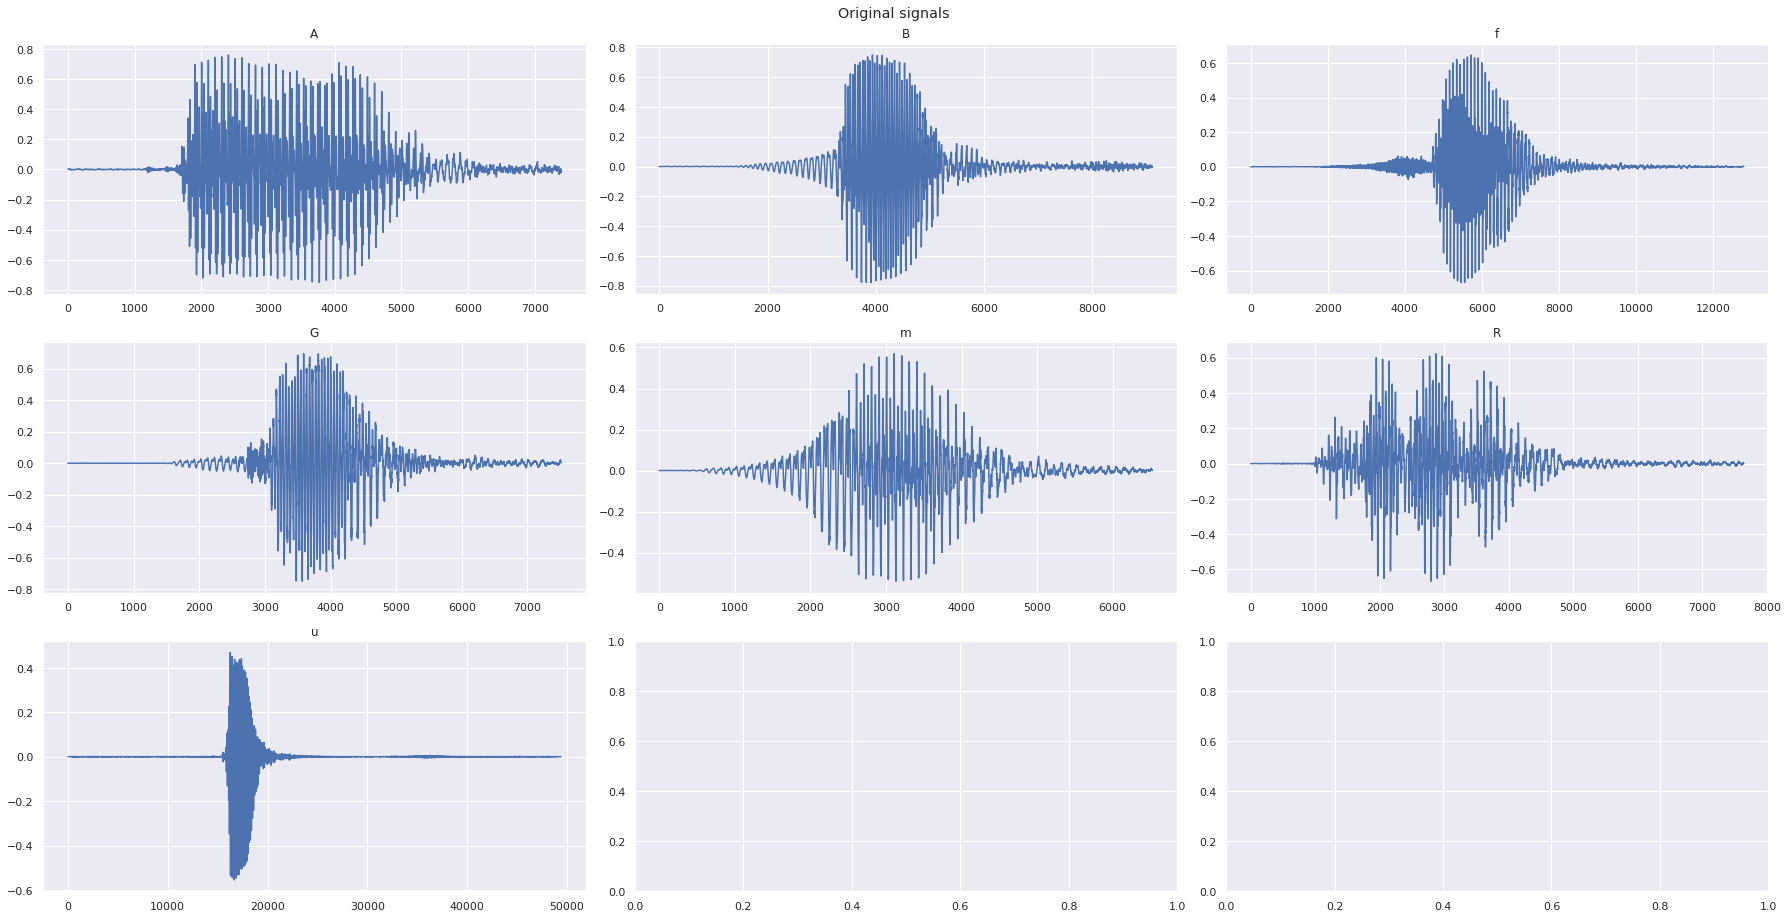

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 13))
for i in range(7):
    axes[i // 3][i % 3].plot(sounds[i])
    axes[i // 3][i % 3].set_title(phonemes[i])

fig.suptitle('Original signals')
plt.tight_layout()

In [23]:
slices = [
    slice(-6766, None),     # A
    slice(1500, 1500+6766), # B
    slice(2100, 2100+6766), # f
    slice(-6766, None),     # G
    slice(None, None),      # m
    slice(500, 500+6766),   # R 
    slice(15000, 15000+6766)# u
]
cut = [snd[slc] for snd, slc in zip(sounds, slices)]
cut[4] = np.concatenate((cut[4], np.zeros(6766 - 6526))) # too small

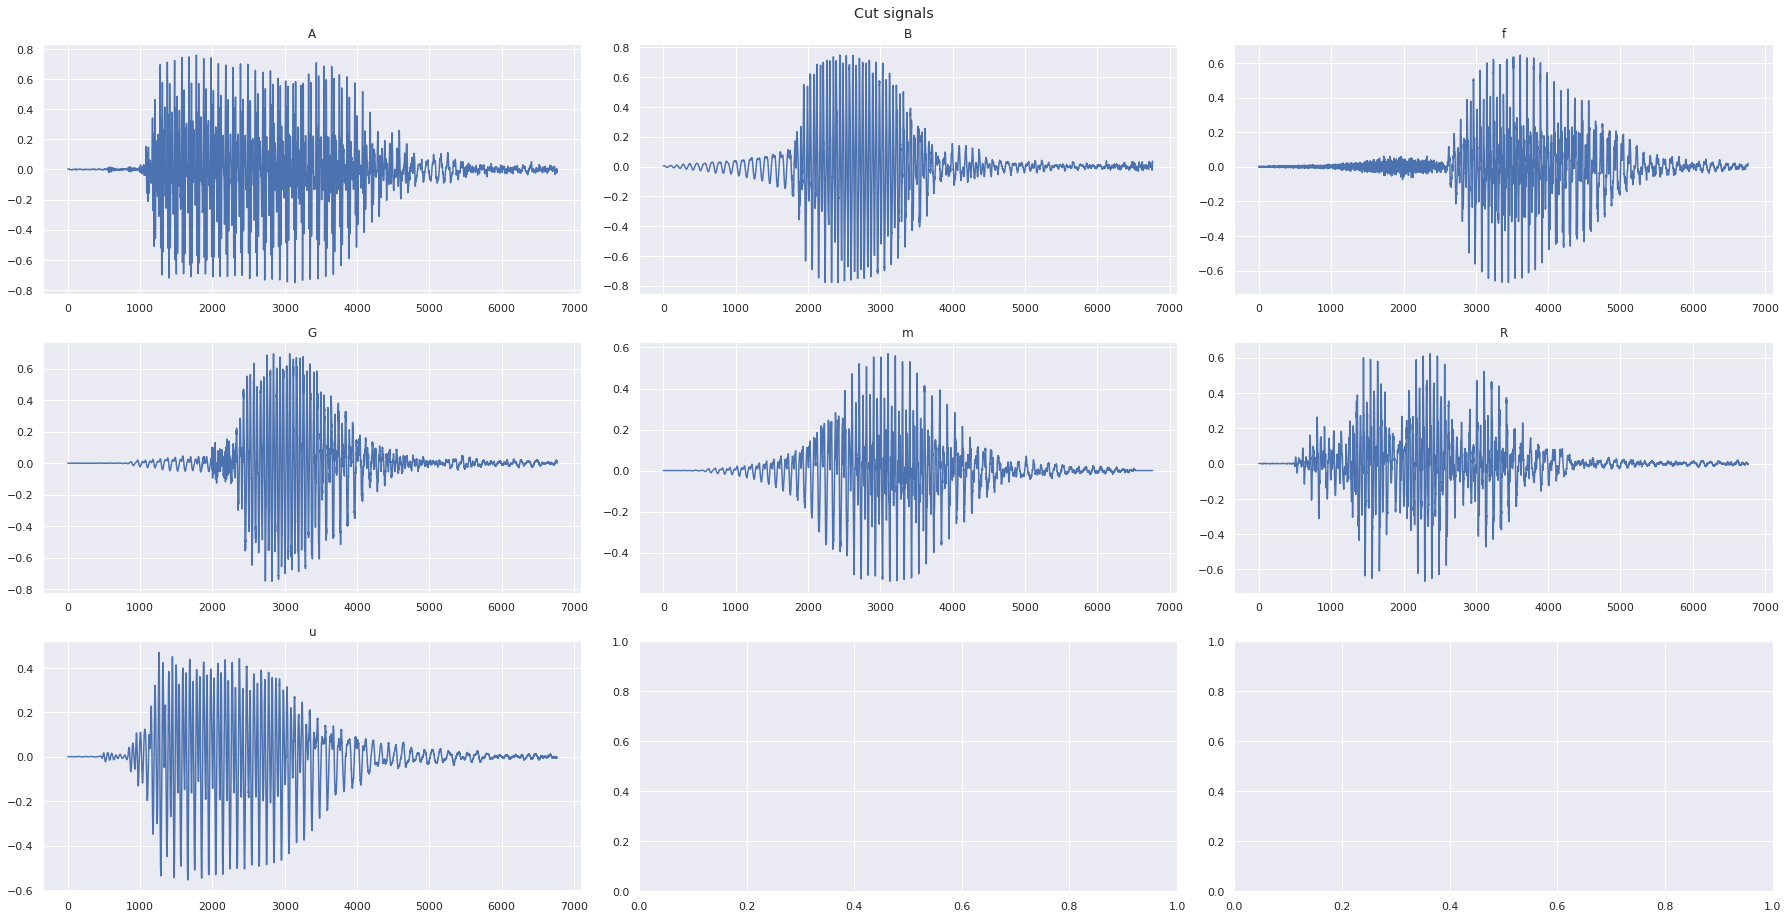

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 13))
for i in range(7):
    axes[i // 3][i % 3].plot(cut[i])
    axes[i // 3][i % 3].set_title(phonemes[i])

fig.suptitle('Cut signals')
plt.tight_layout()

In [25]:
# to spectrums
# 257 freq bins
# 54 frames

FRAME_SIZE = 512
HOP_LENGTH = 118

specs = [np.abs(librosa.stft(s, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, center=False))
         for s in cut]
specs = [np.zeros((257, 54))] + specs

In [26]:
specs = [s.T.reshape(9, -1) for s in specs]
specs = np.stack(specs)
specs.shape

(8, 9, 1542)

In [27]:
test = specs.reshape(8, 54, 257).reshape(-1, 257).T
res = restore(test, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)
res.shape

(51370,)

In [28]:
wavfile.write(os.path.join(path, 'restored.wav'), 22050, res)

In [29]:
# saving spectrums

with open(os.path.join(path, 'spectrums.pickle'), 'wb') as handle:
    pickle.dump(specs, handle)

# X Operator

AX = B

In [32]:
A = np.loadtxt(os.path.join(path, 'converted', 'listen-noise', 'A.csv'), delimiter=',', ndmin=2)
y = np.loadtxt(os.path.join(path, 'converted', 'listen-noise', 'y.csv'), delimiter=',', ndmin=2)
with open(os.path.join(path, 'spectrums.pickle'), 'rb') as handle:
    specs = pickle.load(handle)
specs.shape

(8, 9, 1542)

In [36]:
y[y > 10] = y[y > 10] - 10
B = specs[y.astype(int)]
B.shape

(242, 1, 9, 1542)

In [39]:
B = B.reshape(-1, 1542)
A.shape, B.shape

((2178, 36), (2178, 1542))

In [40]:
A_inv = np.linalg.pinv(A)
X = A_inv @ B

In [54]:
res = A @ X
# res = restore_matrix(res, FRAME_SIZE, HOP_LENGTH)
# wavfile.write(os.path.join(path, 'restored.wav'), 22050, res)
np.abs(res - B)

array([[2.33834530e-01, 1.37753614e-01, 1.03015914e-01, ...,
        6.12158016e-05, 8.08596361e-05, 1.07738976e-04],
       [3.09528110e-01, 3.28251069e-01, 1.38166126e-01, ...,
        7.66012467e-04, 3.51006604e-04, 3.90558682e-04],
       [1.85038391e+00, 1.22227383e+00, 7.28343498e-01, ...,
        1.18906044e-03, 7.73835412e-04, 2.10433405e-05],
       ...,
       [8.67400198e-02, 5.48306727e-02, 4.19291317e-02, ...,
        6.20356080e-05, 2.73701176e-05, 1.63093208e-05],
       [1.07090582e-01, 6.07923696e-02, 3.75895453e-02, ...,
        5.26871884e-05, 3.53029001e-05, 2.38814015e-05],
       [9.72243381e-02, 5.79379322e-02, 3.70182891e-02, ...,
        8.65227330e-05, 4.05416114e-05, 2.15450692e-05]])

In [56]:
A = np.random.rand(20, 1000)
B = np.random.rand(20, 7000)

A_inv = np.linalg.pinv(A)
X = A_inv @ B

np.linalg.norm(np.abs(B - A @ X))

5.107430922377947e-13